<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

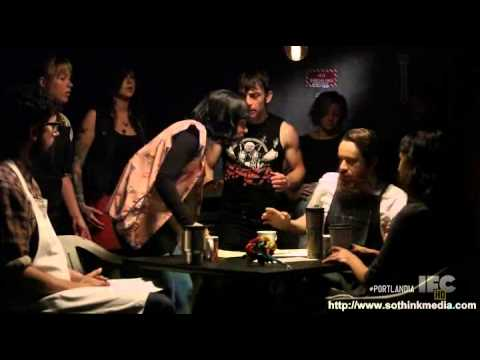

In [49]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [50]:
%pwd

'/Users/yingwang/Desktop/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [97]:
import pandas as pd

url = "https://raw.githubusercontent.com/KristineYW/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [98]:
shops.shape

(7616, 3)

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [99]:
# Import libraries

from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [100]:
# Tokenize text to remove non-alphanumeric characters

def tokenize(text):

    tokens = re.sub('[^a-zA-Z ]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [101]:
shops['tokens'] = shops['full_review_text'].apply(tokenize)

shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[checkin, love, love, loved, the, atmosphere, ..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[listed, in, date, night, austin, ambiance, in..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[checkin, listed, in, brunch, spots, i, loved,..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[very, cool, decor, good, drinks, nice, seatin..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[checkin, they, are, located, within, the, nor..."


In [102]:
# To take the overall word/token count:

# Import Counter 
from collections import Counter

# Instantiate Counter
counts = Counter()

# Apply instantiated counter to tokens column
shops['tokens'].apply(lambda x: counts.update(x))

# Check 10 most common words in the tokens column
counts.most_common(10)

[('the', 34809),
 ('and', 26651),
 ('a', 22756),
 ('i', 20249),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10354),
 ('was', 9707),
 ('in', 9546)]

In [103]:
# Create lemmatization function to lemmatize the tokens

def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [105]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

In [106]:
shops['full_review_text'][0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [107]:
get_lemmas(shops['full_review_text'][0])

[' ',
 '11/25/2016',
 '1',
 'check',
 'Love',
 'love',
 'love',
 'atmosphere',
 'corner',
 'coffee',
 'shop',
 'style',
 'swing',
 'order',
 'matcha',
 'latte',
 'muy',
 'fantastico',
 'order',
 'get',
 'drink',
 'pretty',
 'streamlined',
 'order',
 'iPad',
 'include',
 'beverage',
 'selection',
 'range',
 'coffee',
 'wine',
 'desire',
 'level',
 'sweetness',
 'checkout',
 'system',
 'get',
 'latte',
 'minute',
 ' ',
 'hope',
 'typical',
 'heart',
 'feather',
 'latte',
 'find',
 'list',
 'possibility',
 'art',
 'idea']

In [59]:
print(shops.shape)
shops.head()

(7616, 5)


,coffee_shop_name,full_review_text,star_rating,tokens,lemmas
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[checkin, love, love, loved, the, atmosphere, ...","[ , 11/25/2016, 1, check, Love, love, love, at..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[listed, in, date, night, austin, ambiance, in...","[ , 12/2/2016, list, Date, Night, Austin, Ambi..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[checkin, listed, in, brunch, spots, i, loved,...","[ , 11/30/2016, 1, check, list, Brunch, Spots,..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[very, cool, decor, good, drinks, nice, seatin...","[ , 11/25/2016, cool, decor, good, drink, nice..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[checkin, they, are, located, within, the, nor...","[ , 12/3/2016, 1, check, locate, Northcross, m..."


In [60]:
shops['star_rating'] = pd.to_numeric(shops['star_rating'].astype(str).str[:3], errors='coerce')

In [61]:
shops['star_rating'].dtype

dtype('float64')

In [62]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [63]:
wc = count(shops['tokens'])

In [64]:
wc.head(30)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
16,the,6847,34809,1.0,0.045412,0.045412,0.899028
30,and,6864,26651,2.0,0.034769,0.080180,0.901261
63,a,6246,22756,3.0,0.029687,0.109868,0.820116
59,i,5532,20249,4.0,0.026417,0.136284,0.726366
35,to,5653,17164,5.0,0.022392,0.158676,0.742253
67,of,5100,12600,6.0,0.016438,0.175114,0.669643
97,is,4999,11999,7.0,0.015654,0.190768,0.656381
21,coffee,4877,10354,8.0,0.013508,0.204276,0.640362
70,was,3765,9707,9.0,0.012664,0.216939,0.494354
99,in,4563,9546,10.0,0.012454,0.229393,0.599133


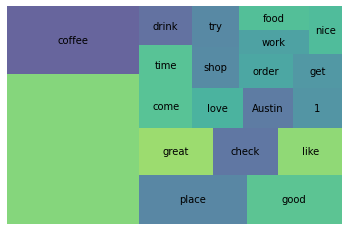

In [65]:
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [66]:
# Use spacy

import spacy 

nlp = spacy.load('en_core_web_lg')

In [67]:
doc = nlp(shops['full_review_text'][0])

In [68]:
for token in doc: 
    print(token.text)

 
11/25/2016
1
check
-
in
Love
love
loved
the
atmosphere
!
Every
corner
of
the
coffee
shop
had
its
own
style
,
and
there
were
swings
!
!
!
I
ordered
the
matcha
latte
,
and
it
was
muy
fantastico
!
Ordering
and
getting
my
drink
were
pretty
streamlined
.
I
ordered
on
an
iPad
,
which
included
all
beverage
selections
that
ranged
from
coffee
to
wine
,
desired
level
of
sweetness
,
and
a
checkout
system
.
I
got
my
latte
within
minutes
!
 
I
was
hoping
for
a
typical
heart
or
feather
on
my
latte
,
but
found
myself
listing
out
all
the
possibilities
of
what
the
art
may
be
.
Any
ideas
?


In [69]:
STOP_WORDS = nlp.Defaults.stop_words.union(['coffee', 'place', 'shop', 'austin', 1, 'order', 'check', 'in', '1', 'listed', ' ', 'coffeeshop'])

In [70]:
from spacy.tokenizer import Tokenizer

In [71]:
tokens = []

for doc in nlp.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if (token.is_stop == False) & (token.is_punct == False):
            if token.text.lower() not in STOP_WORDS:
                doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [72]:
shops['tokens'] 

0       [11/25/2016, love, love, loved, atmosphere, co...
1       [12/2/2016, date, night, ambiance, beautiful, ...
2       [11/30/2016, brunch, spots, loved, eclectic, h...
3       [11/25/2016, cool, decor, good, drinks, nice, ...
4       [12/3/2016, located, northcross, mall, shoppin...
                              ...                        
7611    [2/19/2015, actually, step, restaurant, chance...
7612    [1/21/2016, ok, steeping, room, awesome, great...
7613    [4/30/2015, loved, coming, tea, atmosphere, pr...
7614    [8/2/2015, food, average, booths, feel, clean,...
7615    [5/23/2015, finally, stopped, lunch, colleague...
Name: tokens, Length: 7616, dtype: object

In [73]:
# Use lemmatization

def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
                lemmas.append(token.lemma_)
    
    return lemmas
    

In [74]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

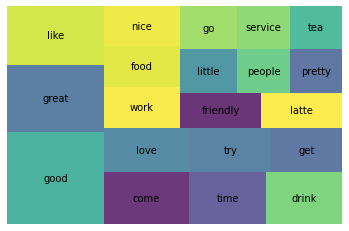

In [75]:
# View overall count

wc2 = count(shops['lemmas'])
wc2_top20 = wc2[wc2['rank'] <= 20]

squarify.plot(sizes=wc2_top20['pct_total'], label=wc2_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

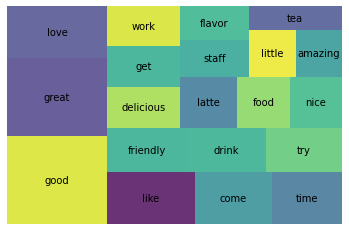

In [76]:
# View count by rating = 5.0

shops_5 = shops.loc[shops['star_rating'] == 5.0] 

wc_5 = count(shops_5['lemmas']) 
wc_5_top20 = wc_5[wc_5['rank'] <= 20]

squarify.plot(sizes=wc_5_top20['pct_total'], label=wc_5_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

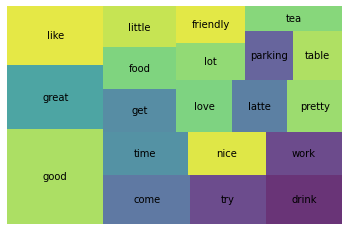

In [77]:
# View count by rating = 4.0

shops_4 = shops.loc[shops['star_rating'] == 4.0] 

wc_4 = count(shops_4['lemmas']) 
wc_4_top20 = wc_4[wc_4['rank'] <= 20]

squarify.plot(sizes=wc_4_top20['pct_total'], label=wc_4_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

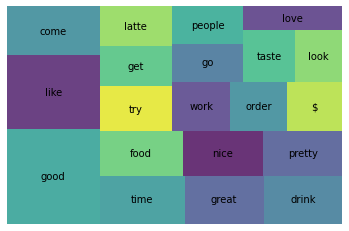

In [78]:
# View count by rating = 3.0

shops_3 = shops.loc[shops['star_rating'] == 3.0] 

wc_3 = count(shops_3['lemmas']) 
wc_3_top20 = wc_3[wc_3['rank'] <= 20]

squarify.plot(sizes=wc_3_top20['pct_total'], label=wc_3_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

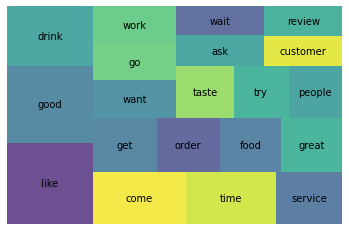

In [79]:
# View count by rating = 2.0

shops_2 = shops.loc[shops['star_rating'] == 2.0] 

wc_2 = count(shops_2['lemmas']) 
wc_2_top20 = wc_2[wc_2['rank'] <= 20]

squarify.plot(sizes=wc_2_top20['pct_total'], label=wc_2_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

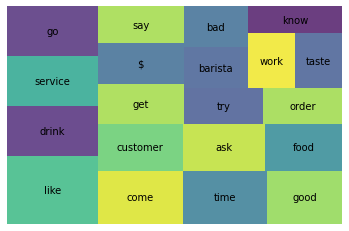

In [80]:
# View count by rating = 1.0

shops_1 = shops.loc[shops['star_rating'] == 1.0] 

wc_1 = count(shops_1['lemmas']) 
wc_1_top20 = wc_1[wc_1['rank'] <= 20]

squarify.plot(sizes=wc_1_top20['pct_total'], label=wc_1_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [81]:
shops_ratings = shops[['lemmas', 'star_rating']].copy()

In [82]:
shops_ratings['lemmas'].apply(pd.Series) \
    .merge(shops_ratings, right_index = True, left_index = True) \
    .drop(['lemmas'], axis=1) \
    .melt(id_vars = 'star_rating', value_name='lemma')

,star_rating,variable,lemma
0,5.0,0,11/25/2016
1,4.0,0,12/2/2016
2,4.0,0,11/30/2016
3,2.0,0,11/25/2016
4,4.0,0,12/3/2016
...,...,...,...
2932155,4.0,384,NaN
2932156,5.0,384,NaN
2932157,4.0,384,NaN
2932158,3.0,384,NaN


In [83]:
shops_ratings2 = shops_ratings.dropna(axis=1)

print(shops_ratings2.shape)
shops_ratings2.head()

(7616, 2)


,lemmas,star_rating
0,"[11/25/2016, Love, love, love, atmosphere, cor...",5.0
1,"[12/2/2016, Date, Night, Ambiance, beautiful, ...",4.0
2,"[11/30/2016, Brunch, Spots, love, eclectic, ho...",4.0
3,"[11/25/2016, cool, decor, good, drink, nice, s...",2.0
4,"[12/3/2016, locate, Northcross, mall, shopping...",4.0


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [84]:
# Concatenate the good-rated dataframes

wc_good = wc_4.append(wc_5)

wc_good.shape

(22920, 7)

In [85]:
# Sanity check to make sure the dataframe will do the correct thing

wc_good.loc[wc_good['word']=='good'] 

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
155,good,1228,1892,1.0,0.016460,0.016460,0.520339
102,good,1701,2449,1.0,0.016065,0.016065,0.450000


In [86]:
# Group by the lemma/word and aggregate the counts

wc_good_group = wc_good.groupby('word').sum()

In [87]:
# Check data to make sure that they are correct

wc_good_group.sort_values(by=['count'])

,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
word,,,,,,
照り焼きボウル、チキンカツ、唐揚げなど色々！セットはライスかトースト、サラダ、とマシュポテトサラダ付き。日本の味が恋しい時はSAーTEN！アイスモカも美味しいでーす*\(^o^)/*本立てコーナーには日本雑誌やマンガ自由読み用ありまーす,1,1,8052.0,0.000009,0.978077,0.000424
abc,1,1,11079.0,0.000007,0.991675,0.000265
abbreviate,1,1,9541.0,0.000007,0.981586,0.000265
aaahhmanze,1,1,7995.0,0.000007,0.971445,0.000265
aaaaand,1,1,6858.0,0.000007,0.963986,0.000265
...,...,...,...,...,...,...
come,1480,1988,9.0,0.014922,0.100773,0.491658
love,1565,2053,16.0,0.014760,0.138848,0.490586
like,1677,2434,7.0,0.018453,0.085852,0.567810


In [88]:
bad_shops = [wc_1,wc_2,wc_3]
wc_bad = pd.concat(bad_shops)

wc_bad.shape

(13147, 7)

In [89]:
wc_bad.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
114,like,104,173,1.0,0.012022,0.012022,0.374101
56,drink,60,128,2.0,0.008895,0.020917,0.215827
30,service,94,128,3.0,0.008895,0.029812,0.338129
86,go,82,128,4.0,0.008895,0.038707,0.294964
121,come,87,127,5.0,0.008826,0.047533,0.312950


In [90]:
wc_bad_group = wc_bad.groupby('word').sum()

In [91]:
wc_bad_group.sort_values(by=['count'])

,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
word,,,,,,
execrable,1,1,2506.0,0.000069,0.952397,0.003597
gamble,1,1,3290.0,0.000027,0.939203,0.001355
gallo,1,1,3110.0,0.000027,0.934352,0.001355
galaxy,1,1,2316.0,0.000042,0.912884,0.002174
gain,1,1,4178.0,0.000042,0.990348,0.002174
...,...,...,...,...,...,...
drink,364,610,11.0,0.025182,0.113560,0.732571
time,423,613,15.0,0.024956,0.152666,0.879819
come,452,650,12.0,0.026085,0.127710,0.926270


In [92]:
wc_bad_group = wc_bad_group.rename(columns={'count': 'count_bad'})
wc_good_group = wc_good_group.rename(columns={'count': 'count_good'})

In [93]:
wc_all = pd.merge(wc_bad_group, wc_good_group, on=['word'])
print(wc_all.shape)
wc_all.head()

(6166, 12)


,appears_in_x,count_bad,rank_x,pct_total_x,cul_pct_total_x,appears_in_pct_x,appears_in_y,count_good,rank_y,pct_total_y,cul_pct_total_y,appears_in_pct_y
word,,,,,,,,,,,,
,46,79,558.0,0.003409,1.332007,0.108460,156,214,532.0,0.001539,1.015988,0.049706
,84,119,397.0,0.004521,1.161358,0.160809,278,391,249.0,0.003001,0.746518,0.097422
,1,1,3407.0,0.000042,0.958273,0.002174,11,16,5133.0,0.000131,1.718516,0.004024
,3,3,3749.0,0.000153,1.793842,0.007945,4,4,11715.0,0.000031,1.909554,0.001377
,1,1,4266.0,0.000042,0.994009,0.002174,1,1,7435.0,0.000009,0.972709,0.000424


In [94]:
wc_all.sort_values(by=['count_good'])

,appears_in_x,count_bad,rank_x,pct_total_x,cul_pct_total_x,appears_in_pct_x,appears_in_y,count_good,rank_y,pct_total_y,cul_pct_total_y,appears_in_pct_y
word,,,,,,,,,,,,
loved,1,1,1897.0,0.000069,0.910076,0.003597,1,1,12132.0,0.000007,0.998583,0.000265
Austinish,3,3,1401.0,0.000125,0.838998,0.006522,1,1,9534.0,0.000009,0.990970,0.000424
caliber,1,1,2986.0,0.000042,0.940758,0.002174,1,1,8798.0,0.000007,0.976712,0.000265
campaign,2,2,7579.0,0.000069,1.908115,0.003529,1,1,8357.0,0.000009,0.980730,0.000424
campy,1,1,3204.0,0.000027,0.936885,0.001355,1,1,12020.0,0.000007,0.997848,0.000265
...,...,...,...,...,...,...,...,...,...,...,...,...
come,452,650,12.0,0.026085,0.127710,0.926270,1480,1988,9.0,0.014922,0.100773,0.491658
love,204,245,200.0,0.008404,0.776563,0.357940,1565,2053,16.0,0.014760,0.138848,0.490586
like,596,945,4.0,0.037326,0.053306,1.196358,1677,2434,7.0,0.018453,0.085852,0.567810


In [95]:
wc_all = wc_all[['count_bad','count_good']]
wc_all.sort_values(by=['count_good'])

,count_bad,count_good
word,,
loved,1,1
Austinish,3,1
caliber,1,1
campaign,2,1
campy,1,1
...,...,...
come,650,1988
love,245,2053
like,945,2434


In [96]:
wc_all['diff'] = abs(wc_all['count_good'] - wc_all['count_bad'])
wc_all.sort_values(by=['diff'], ascending=False)

,count_bad,count_good,diff
word,,,
good,1000,4341,3341
great,462,3449,2987
love,245,2053,1808
like,945,2434,1489
come,650,1988,1338
...,...,...,...
coat,3,3,0
3/5/2015,1,1,0
populate,1,1,0


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

